In [1]:
import librosa
import numpy as np
from data_files.CQT import cqt
import pandas as pd
import torch
import scipy
from sklearn.model_selection import train_test_split

from data_files.dataloader import MedleyDBLoader, MDBMelodySynthLoader, MIR1KLoader
# from data_files.dataset import CQT_Dataset

import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
fs = 16000

medleyDB = MedleyDBLoader(fs)
mdbSynth = MDBMelodySynthLoader(fs)
mir1k = MIR1KLoader(fs)

In [6]:
id_list = medleyDB.get_ids()
len(id_list)

65

In [7]:
songs = []
f0s = []
for i,x in enumerate(id_list[:5]):
    so, f0 = medleyDB.load_data(x)
    print(so.shape, x)
    songs.append(librosa.to_mono(so))
    f0s.append(f0)

(2, 4807500) MatthewEntwistle_FairerHopes_STEM_14
(2, 1071452) MusicDelta_LatinJazz_STEM_04
(2, 2350973) BigTroubles_Phantom_STEM_04
(2, 3131871) ClaraBerryAndWooldog_Stella_STEM_07
(2, 5072236) PortStWillow_StayEven_STEM_08


In [65]:
sum([np.sum(i) for i in f0s])

66699551.87484806

In [9]:
Cqtt = np.zeros((1, 190))
f0s_inter = np.zeros(1)
for s, f in zip(songs, f0s):
    print("Songs shape: ", s.shape,"F0 shape: ", f.shape )
    C = np.abs(librosa.cqt(s, sr=fs, hop_length=512, #window=librosa.filters.get_window('hann', Nx=1024, fftbins=False), 
            fmin= librosa.note_to_hz('C1'),
            n_bins=190, bins_per_octave=24))
    print("Cqt shape: ", C.shape)
    Cqtt = np.vstack((Cqtt, C.T))
    inter = scipy.interpolate.interp1d(x=f[0], y=f[2], axis=0)
    f0_inter = inter(C[0])
    f0s_inter = np.concatenate((f0s_inter, f0_inter))
    print("Reshape F0: ", f0_inter.shape )
print("CQT Shape: ", Cqtt.shape)
print("F0 shape: ", f0s_inter.shape)

Songs shape:  (4807500,) F0 shape:  (3, 51761)
Cqt shape:  (190, 9390)
Reshape F0:  (9390,)
Songs shape:  (1071452,) F0 shape:  (3, 11536)
Cqt shape:  (190, 2093)
Reshape F0:  (2093,)
Songs shape:  (2350973,) F0 shape:  (3, 25312)
Cqt shape:  (190, 4592)
Reshape F0:  (4592,)
Songs shape:  (3131871,) F0 shape:  (3, 33720)
Cqt shape:  (190, 6117)
Reshape F0:  (6117,)
Songs shape:  (5072236,) F0 shape:  (3, 54611)
Cqt shape:  (190, 9907)
Reshape F0:  (9907,)
CQT Shape:  (32100, 190)
F0 shape:  (32100,)


In [10]:
# remove zero rows
Cqtt = Cqtt[1:, :]
f0s_inter = f0s_inter[1:]
#elevate f0
f0s_inter = f0s_inter.reshape(-1, 1)
print("CQT Shape: ", Cqtt.shape)
print("F0 shape: ", f0s_inter.reshape(-1,1).shape)

CQT Shape:  (32099, 190)
F0 shape:  (32099, 1)


In [15]:
file_path = "./data/CQT_dataset/"+"medley" + ".npy"

# print(file_path)
with open(file_path, 'wb') as f:
    np.save(file=f, arr=Cqtt)

In [16]:
import os 

os.path.abspath(os.getcwd())

'/Users/jibaksarkar/Documents/AI_MS_FAU/Sem_3/MPA Project/Code/Mini_SPICE'

In [17]:
# make the last column as f0s
dataset = np.hstack((Cqtt, f0s_inter))

In [59]:
np.sum(f0s_inter)

0.0

In [25]:
# librosa.cqt_frequencies(n_bins=190, fmin=librosa.note_to_hz('C1'), bins_per_octave=24)

In [58]:
# as 190 is feature number so we transpose
data = pd.DataFrame(data=dataset)

In [19]:
train, val = train_test_split(data, train_size=0.8, test_size=0.2, random_state=1)
train.shape

(25679, 191)

In [66]:
dataa = train.iloc[:, :-1]
# dataa.head()

In [14]:
t_batch = torch.utils.data.DataLoader(CQT_Dataset(data=train, mode='train'), batch_size=64, shuffle=False)

In [16]:
batch_counter = 0
for b in t_batch:
    batch_counter += 1
    d, s1, s2 ,f = b
    #print(s.shape, d.shape, f.shape)
print(batch_counter)

211


## Rough works

In [74]:
'/home/jeet/Documents/ai_fau_study/Sose23/MPA_project/Mini_SPICE/datasets/MIR-1K/Wavfile/abjones_1_03.wav'
my_id = 'abjones_1_03'

x, f0 = mir1k.load_data(my_id)
f0.shape, x.shape

((3, 355), (1, 114177))

In [12]:
x.shape

(1, 114177)

In [43]:
114177/512


223.001953125

In [36]:
32*16

512

In [76]:
ipd.Audio(x, rate=16000)

In [4]:
print(f0[0].shape, f0[2].shape, f0[1].shape)

(355,) (355,) (355,)


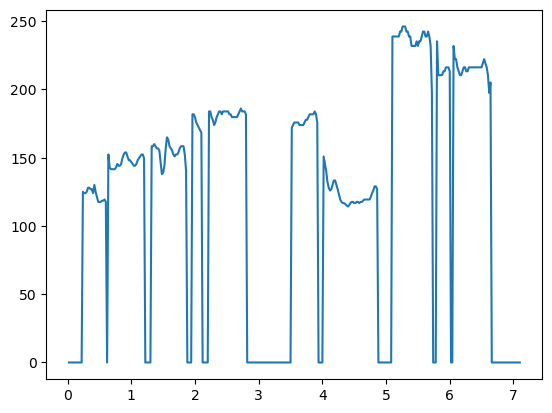

In [9]:
from matplotlib import pyplot as plt

plt.plot(f0[0], f0[2])

In [57]:
C = np.abs(librosa.cqt(x, sr=16000, hop_length=512, #window=librosa.filters.get_window('hann', Nx=1024, fftbins=False), 
            fmin= librosa.note_to_hz('C1'),
            n_bins=190, bins_per_octave=24))
C.shape

(1, 190, 224)

In [16]:
inter = scipy.interpolate.interp1d(x=f0[0], y=f0[2], axis=0, fill_value="extrapolate")

In [37]:
13089*512/16000

418.848

In [54]:
t_cqt = np.arange(0, C.shape[1], 1)*512/16000
len(t_cqt)

190

In [58]:
t_cqt2 = np.arange(0, C.shape[2], 1)*512/16000
len(t_cqt2)

224

In [60]:
f0_interpolated2 = inter(t_cqt2)
f0_interpolated2.shape

(224,)

In [63]:
f0_interpolated = inter(t_cqt)
f0_interpolated.shape

(190,)

In [ ]:
f0_inter

In [45]:
len(f0[0])

355

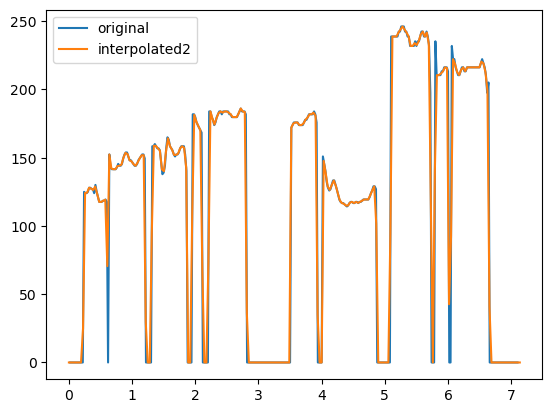

In [69]:
plt.plot(f0[0], f0[2], label='original')
plt.plot(t_cqt2, f0_interpolated2, label='interpolated2')
#plt.plot(t_cqt, f0_interpolated, label='interpolated')
plt.legend()

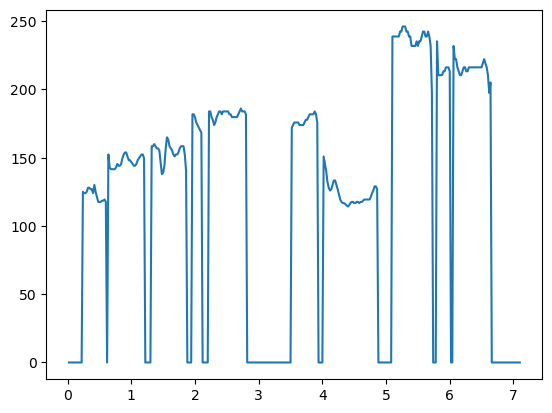

In [24]:
plt.plot(f0[0], f0[2])

In [34]:
f0_interpolated.sum()

720277.0891537461

In [23]:
(256/44100)*16000

92.87981859410431

(72148,) (72148,) (72148,)


In [21]:
# plt.plot(f0[0], f0[2])

In [25]:
16000*418

6688000

In [26]:
(6701068/16000)

418.81675

In [27]:
diff, slice1, slice2, f0 = next(iter(t_batch))
print(f"diff batch shape: {diff.size()}")
print(f"slice1 batch shape: {slice1.size()}")
print(f"slice2 batch shape: {slice2.size()}")

diff batch shape: torch.Size([64])
slice1 batch shape: torch.Size([64, 128])
slice2 batch shape: torch.Size([64, 128])


In [20]:
# Cell output takes up lot of memory in the repo, clear it everytime
# ipd.display(ipd.Audio(x, rate=fs))

In [5]:
#y, sr = librosa.load('data/MusicDelta_Hendrix_STEM_04.wav')
C = np.abs(librosa.cqt(x, sr=fs, hop_length=512, #window=librosa.filters.get_window('hann', Nx=1024, fftbins=False), 
            fmin= librosa.note_to_hz('C1'),
            n_bins=190, bins_per_octave=24)) # n_bins upto 113


In [16]:
C = np.sum(C, axis=0)

In [17]:
C[0].shape

(13089,)

In [32]:
6701068/13089

511.96179998472

In [33]:
np.sum(C, axis=0).shape

(13089,)

In [34]:
plt.pcolormesh(C[1,:,:], cmap='gray_r')
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
plt.pcolormesh(np.sum(C, axis=0), cmap='gray_r')
plt.show()

In [ ]:
librosa.note_to_hz('B8')

In [ ]:
C_ = np.abs(cqt(x, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('B8'), bins=24, fs=sr)['spCQT'])

In [ ]:
C_.shape

In [ ]:
plt.pcolormesh(C_)
plt.show()

In [ ]:
np.divmod(190, 24)

In [ ]:
np.divmod(88539, 64)
